Epoch 1/50 — Train loss: 1.0041, acc: 0.4864 — Val loss: 0.8795, acc: 0.5547
Epoch 2/50 — Train loss: 0.8381, acc: 0.6070 — Val loss: 0.7780, acc: 0.6797
Epoch 3/50 — Train loss: 0.7462, acc: 0.6673 — Val loss: 0.7600, acc: 0.6484
Epoch 4/50 — Train loss: 0.7227, acc: 0.6770 — Val loss: 0.7832, acc: 0.6562
Epoch 5/50 — Train loss: 0.6670, acc: 0.7062 — Val loss: 0.8009, acc: 0.6641
Epoch 6/50 — Train loss: 0.6128, acc: 0.7393 — Val loss: 0.7017, acc: 0.6797
Epoch 7/50 — Train loss: 0.5957, acc: 0.7607 — Val loss: 0.6324, acc: 0.7266
Epoch 8/50 — Train loss: 0.5164, acc: 0.7918 — Val loss: 0.6948, acc: 0.7188
Epoch 9/50 — Train loss: 0.4532, acc: 0.8366 — Val loss: 0.6847, acc: 0.7188
Epoch 10/50 — Train loss: 0.4494, acc: 0.8249 — Val loss: 0.5896, acc: 0.7656
Epoch 11/50 — Train loss: 0.3682, acc: 0.8716 — Val loss: 0.6690, acc: 0.7188
Epoch 12/50 — Train loss: 0.3982, acc: 0.8463 — Val loss: 0.6399, acc: 0.7188
Epoch 13/50 — Train loss: 0.3761, acc: 0.8502 — Val loss: 0.6249, acc: 0.

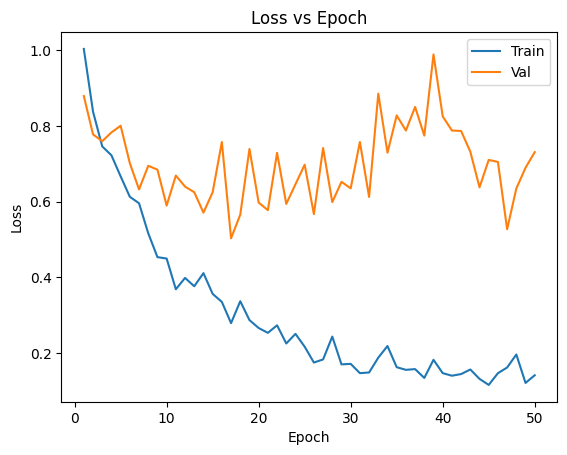

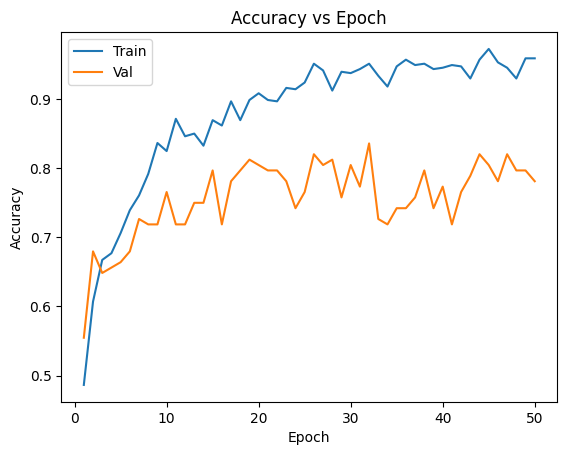

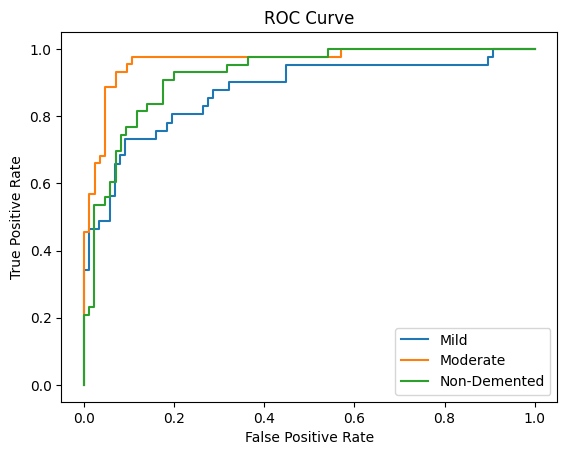

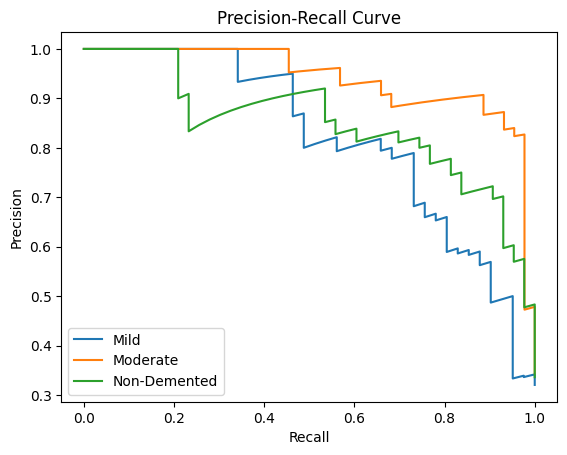

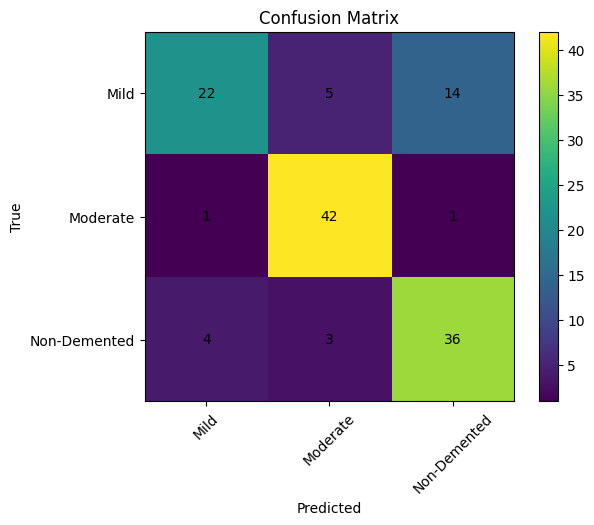

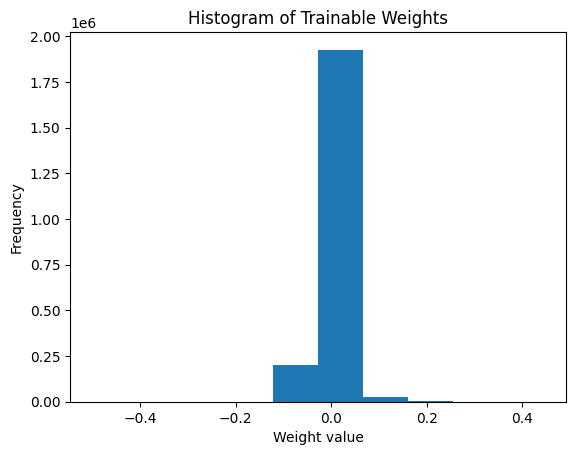

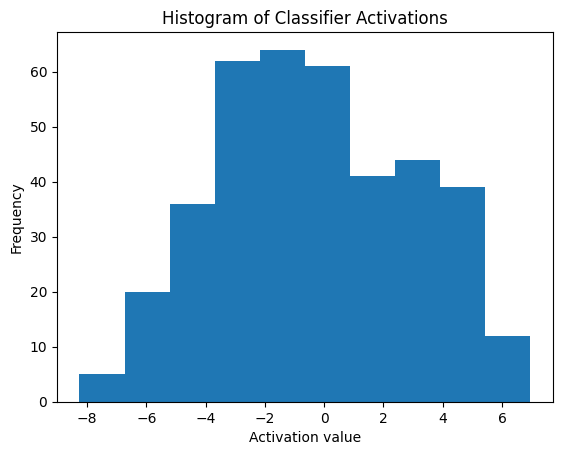

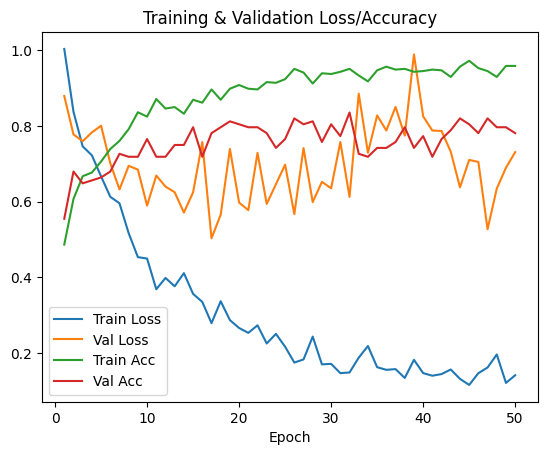

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import (
    accuracy_score, roc_curve, auc,
    precision_recall_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np

# === Configuration ===
data_dir     = r"C:\Users\aruna\Documents\projects\code_base\data\training"
num_epochs   = 50
batch_size   = 8
lr           = 1e-4
weight_decay = 1e-5
val_split    = 0.2
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes  = len(os.listdir(data_dir))
class_names  = sorted(os.listdir(data_dir))  # must match ImageFolder order

# === Transforms & Datasets ===
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])
full_ds   = ImageFolder(root=data_dir, transform=transform)
val_size  = int(len(full_ds) * val_split)
train_size= len(full_ds) - val_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

# === Model Setup ===
model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for name, param in model.named_parameters():
    if name.startswith("features.denseblock4") or name.startswith("classifier"):
        param.requires_grad = True
in_feats = model.classifier.in_features
model.classifier = nn.Linear(in_feats, num_classes)
model = model.to(device)

# === Loss & Optimizer ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=lr, weight_decay=weight_decay
)

# === Containers for metrics ===
train_losses, val_losses = [], []
train_accs,   val_accs   = [], []
all_val_labels, all_val_probs = [], []

# === Training & Validation ===
best_val_acc = 0.0
for epoch in range(num_epochs):
    # -- Train --
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        correct   += (preds == labels).sum().item()
        total     += labels.size(0)
    train_loss = running_loss / total
    train_acc  = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # -- Validate --
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    epoch_val_labels, epoch_val_probs = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            out  = model(imgs)
            loss = criterion(out, labels.to(device))
            val_running_loss += loss.item() * imgs.size(0)
            probs = torch.softmax(out, dim=1)
            preds = probs.argmax(dim=1)
            val_correct += (preds.cpu() == labels).sum().item()
            val_total   += labels.size(0)
            epoch_val_labels.extend(labels.numpy())
            epoch_val_probs.extend(probs.cpu().numpy())
    val_loss = val_running_loss / val_total
    val_acc  = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Save last epoch’s validation data for ROC/PR
    if epoch == num_epochs - 1:
        all_val_labels = np.array(epoch_val_labels)
        all_val_probs  = np.array(epoch_val_probs)

    print(
        f"Epoch {epoch+1}/{num_epochs} — "
        f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} — "
        f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_densenet_finetuned.pth")

# === Plotting ===

# 1. Loss vs Epoch
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses)
plt.plot(range(1, num_epochs+1), val_losses)
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train","Val"])
plt.show()

# 2. Accuracy vs Epoch
plt.figure()
plt.plot(range(1, num_epochs+1), train_accs)
plt.plot(range(1, num_epochs+1), val_accs)
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"])
plt.show()

# 3. ROC Curve (one-vs-rest)
plt.figure()
for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(all_val_labels==i, all_val_probs[:,i])
    plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(class_names)
plt.show()

# 4. Precision-Recall Curve
plt.figure()
for i, cls in enumerate(class_names):
    prec, rec, _ = precision_recall_curve(all_val_labels==i, all_val_probs[:,i])
    plt.plot(rec, prec)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(class_names)
plt.show()

# 5. Confusion Matrix
cm = confusion_matrix(all_val_labels, all_val_probs.argmax(axis=1))
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), class_names, rotation=45)
plt.yticks(range(num_classes), class_names)
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.colorbar()
plt.show()

# 6. Histogram of Weights
all_weights = np.hstack([
    p.cpu().detach().numpy().ravel()
    for p in model.parameters() if p.requires_grad
])
plt.figure()
plt.hist(all_weights)
plt.title("Histogram of Trainable Weights")
plt.xlabel("Weight value")
plt.ylabel("Frequency")
plt.show()

# 7. Histogram of Activations (classifier layer)
activs = []
model.eval()
with torch.no_grad():
    for imgs, _ in val_loader:
        imgs = imgs.to(device)
        x = model.features(imgs)
        x = nn.functional.relu(x, inplace=False)
        x = nn.functional.adaptive_avg_pool2d(x, (1,1)).flatten(1)
        acts = model.classifier(x).cpu().numpy()
        activs.append(acts)
activs = np.vstack(activs)
plt.figure()
plt.hist(activs.ravel())
plt.title("Histogram of Classifier Activations")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show()

# 8. Combined Training vs Validation Loss/Accuracy
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), val_losses,   label="Val Loss")
plt.plot(range(1, num_epochs+1), train_accs,   label="Train Acc")
plt.plot(range(1, num_epochs+1), val_accs,     label="Val Acc")
plt.title("Training & Validation Loss/Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()
